# Exam 2, Part 1 (50 points)

This started off as a homework assignment, but it seems a bit too much to be just a part of the homework, and it may require a good bit of time to study, design, implement, and tune. So this is the first 50% of Exam 2.

You may discuss this with other people. You may not share code. You may ask me any questions, but you should study the timing synchronization lectures and have some ideas before asking me. My goal is for you to succeed on this, but you will have to put in some effort to get it to work. 


In [1]:
# The usual imports

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import norm

def q(x):
  return norm.sf(x)

In this problem, you will implement a digital timing tracking algorithm. I suggest to implement the early-late gate strategy. 

To use such a strategy, you must use a more realistic pulse shape than the rectangular pulse. We will use this one:

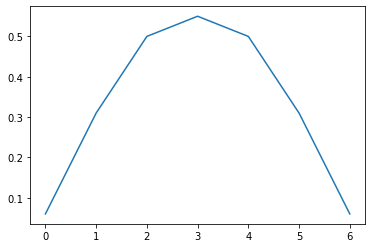

In [2]:
# shaped transmission pulse
pulse = [0.06, 0.31, 0.5, 0.55, 0.5, 0.31, 0.06]
plt.plot(pulse);

Note that the energy of this pulse is approximately 1:

In [3]:
np.linalg.norm(pulse)

1.000949549178179

Here is a function to generate a random vector of bits and modulate them using binary antipodal signaling with this pulse shape. How it works is to convert the signed bit stream to a sequence of impulses by inserting the appropriate number of zeros and then convolve the impulse stream with the pulse shape.

It returns the bits, the noiseless signal, and the noisy signal:

In [4]:
def modulated_bits( num_bits, pulse, ebno_db):# Number of bits to simulate
  
  
  samples_per_symbol = len(pulse)

  ebno = 10 ** (ebno_db/10)
  #sigma = np.sqrt(1/(2*ebno)/samples_per_symbol)
  sigma = np.sqrt(1/(2*ebno))


  # Generate bits
  u = npr.randint(2, size=(1,num_bits))

  # Convert to +1, -1
  u2 = -2*u + 1 

  # Append zeros so we can convert to stream of impulses
  z = np.zeros((samples_per_symbol - 1, num_bits))
  u3= np.vstack((u2,z))
  impulses= np.reshape(u3, (1, samples_per_symbol*num_bits), order='F')[0]

  # Now filter and chop off some zero padding:
  s=np.convolve(impulses,pulse)[:-samples_per_symbol]
  
  rng = npr.default_rng()
  n = sigma*rng.standard_normal( len(s) )
  r = s+n
  return u, s, r


And here is some example output:

[[1 1 1 0 1 1 0 0 0 1]]


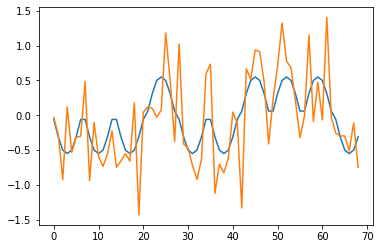

In [5]:
u, s,r  = modulated_bits(10, pulse, 4)
plt.plot(s)
plt.plot(r)
print(u)

Now, in the receiver, we will perform matched filtering, which is just another convolution with the pulse shape (since it has time-reverse symmetry). Here is what the matched-filter output looks like in the absence of noise:

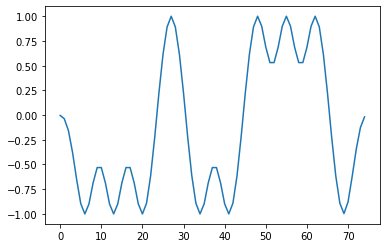

In [6]:
mf_out = np.convolve(s, pulse)
plt.plot(mf_out)

There is a peak at the optimal matched filter sampling times. Since our pulse is 7 samples long, the optimal sampling times are very 7 samples. Since we have 0-indexing, the first sampling time is time 6:

In [7]:
mf_out[6::7]

array([-1.0019, -1.0019, -1.0019,  1.0019, -1.0019, -1.0019,  1.0019,
        1.0019,  1.0019, -0.9983])

Here is what the matched-filter output looks like for the noisy received signal:

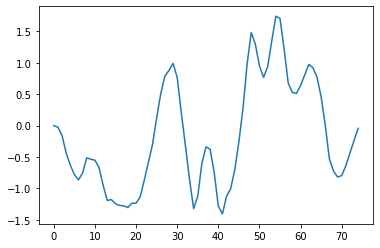

In [8]:
mf_out = np.convolve(r, pulse)
plt.plot(mf_out)

I have written a standard demodulator for you that works perfectly when there are no timing errors:

In [9]:
def demodulate(r, pulse):
  samples_per_symbol = len(pulse)
  decisions=[]

  # Compute the matched filter output
  mf_out = np.convolve(r, pulse)
  
  #First sample time (per description above)
  next_sample_time = samples_per_symbol - 1

  # Loop until we run out of data
  while next_sample_time < len(mf_out) - 1:
    out = mf_out[next_sample_time]
    decisions += [ 1 * (out<0) ]
                 
    # Now implement your timing algorithm (e.g., early-late gate) here
    # by replacing this statment:
    delta = 0             
    
    next_sample_time += (samples_per_symbol + delta)

  return np.array(decisions)



Here is the demodulator in action for our short block of bits:

In [10]:
demodulate(r, pulse), u

(array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1]),
 array([[1, 1, 1, 0, 1, 1, 0, 0, 0, 1]]))

Now, let's check the error rate with no timing synchronization errors:

In [12]:
num_bits = 100_000
ebno_db = 6
ebno = 10 ** (ebno_db / 10)
u, s, r  = modulated_bits(num_bits, pulse, ebno_db)
uhat = demodulate(r, pulse)
error_count = np.count_nonzero(u != uhat)
error_rate= error_count/num_bits
print(f'simulated error rate = {error_rate : .2g}')

print(f'analytical bit error rate = {q(np.sqrt(2*ebno)) : .2g}')

simulated error rate =  0.0024
analytical bit error rate =  0.0024


Everything looks good, right?!?!?

Now load the data for this problem:

In [40]:
import pickle
with open('timing-data.pickle', 'rb') as f:
  r4  = pickle.load(f)
  rt4 = pickle.load(f)
  u4  = pickle.load(f)
  r6  = pickle.load(f)  
  rt6 = pickle.load(f)
  u6  = pickle.load(f)
  r8  = pickle.load(f)
  rt8 = pickle.load(f)  
  u8  = pickle.load(f)
  r20  = pickle.load(f)
  rt20 = pickle.load(f)  
  u20  = pickle.load(f)

Here is what these data sets are: 

* r#  = noisy data at Eb/N0 = # dB
* rt# = noisy data with random timing issues at Eb/N0 = # dB
* u#  = information sequence corresponding to r# and rt#

For instance, let's demodulate r4 and check the error rate:

In [32]:
uhat4 = demodulate(r4, pulse)
error_count4 = np.count_nonzero(u4 != uhat4)
error_rate4 = error_count4/len(uhat4)
print(f'Error rate at 4 db with no timing issues = {error_rate4 : .2g}')

Error rate at 4 db with no timing issues =  0.013


For instance, let's demodulate rt4 and check the error rate when there are timing issues and we don't try to correct for them:

In [33]:
uhat4t = demodulate(rt4, pulse)

The first thing you need to know is that  in the presence of timing errors, you may end up with more or fewer demodulated symbols than you started with:

In [34]:
print(f'original # of bits: {len(u4)}, # of bits after timing errors: {len(uhat4t)}')

original # of bits: 100000, # of bits after timing errors: 99994


So, we will just compare over the minimum of the lengths of these arrays:

In [37]:
ulen4 = min (len(u4), len(uhat4t) )
ulen4

99994

In [39]:
error_count4t = np.count_nonzero(u4[:ulen4] != uhat4t[:ulen4])
error_rate4t = error_count4t/len(uhat4t)
print(f'Error rate at 4 db with no timing issues = {error_rate4t : .2g}')

Error rate at 4 db with no timing issues =  0.49


**That is a problem!!!!** The error rate is almost 1/2, which is as bad as it should ever get. Now, if you look at the function `demodulate()`, you will see that there is already a timing correction delta that will adjust the next matched-filter sample time after each symbol. However, I have set `delta = 0`. 

**YOUR JOB** Design a way to detected timing errors and change delta dynamically. I suggest to use the early-late gate technique described in class.  

**WHAT TO SUBMIT:** Submit a Jupyter notebook that has a new demodulator function called `demodulator2()` that has the same arguments and returns as `demodulator()` but that implements timing tracking. Show the performance of your `demodulator2()` function on the data in the Pickle file. *However: I will evaluate the performance of your tracker on separate samples, and I will assign a grade based on the performance on my data set. So you can't hardcode your function to work for these particular cases.*




Some things to keep in mind:

* The timing at the beginning of each data file is correct and gradually shifts forwards or backwards (corresponding to adding or dropping symbols) according to some random pattern
* You can start with Eb/N0 = 20 to avoid the need to implement a loop filter/smoothing when you are first starting out. 
* Note that we are doing binary antipodal modulation, so you will need to to do something to remove the effect of the modulation before implementing the early-late gate tracker
* To build a timing tracker that will work with noisy data, you will need to smooth the outputs of the early-late computation. I suggest to just keep a buffer of the previous N values and average them together, where N is some parameter you choose. You cannot use the value of $E_b/N_0$ as an input to your function, but you could estimate the noise variance if you wanted to. *I did not find that necessary to get good performance.*
